In [3]:
import torch
import esm
from typing import Union
import torch
import torch.nn as nn

import esm
from esm.modules import ContactPredictionHead, ESM1bLayerNorm, RobertaLMHead, TransformerLayer
import warnings
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, \
                    matthews_corrcoef, ConfusionMatrixDisplay,f1_score, \
                    accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Conv1d, Linear, Dropout, MaxPool1d, functional as F, BatchNorm1d, LazyLinear
from torch.optim import Optimizer
import os
import pandas as pd
import matplotlib.pyplot as plt

import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import random

class ESM2_test(nn.Module):
    def __init__(
        self,
        num_layers: int = 6,
        embed_dim: int = 320,  # Change the embed_dim to match the ESM2 module
        attention_heads: int = 4,  # Change the attention_heads to match the ESM2 module
        alphabet: Union[esm.data.Alphabet, str] = "ESM-1b",
        token_dropout: bool = True,
        linear_in1: int = 320,
        linear_in2: int = 180,
        linear_in3: int = 60,
        linear_in4: int = 30,
        linear_out: int = 1
    ):
        super().__init__()
        _, self.alphabet_ = esm.pretrained.esm2_t6_8M_UR50D()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.attention_heads = attention_heads
        if not isinstance(alphabet, esm.data.Alphabet):
            alphabet = esm.data.Alphabet.from_architecture(alphabet)
        self.alphabet = alphabet
        self.alphabet_size = len(alphabet)
        self.padding_idx = alphabet.padding_idx
        self.mask_idx = alphabet.mask_idx
        self.cls_idx = alphabet.cls_idx
        self.eos_idx = alphabet.eos_idx
        self.prepend_bos = alphabet.prepend_bos
        self.append_eos = alphabet.append_eos
        self.token_dropout = token_dropout
        self.layer1 = nn.Linear(linear_in1, linear_in2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(linear_in2, linear_in3)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(linear_in3, linear_in4)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(linear_in4, linear_out)
        self.sigmoid = nn.Sigmoid()

        self.batch_converter = alphabet.get_batch_converter()
        self._init_submodules()

    def _init_submodules(self):
        self.embed_scale = 1
        self.embed_tokens = nn.Embedding(
            self.alphabet_size,
            self.embed_dim,
            padding_idx=self.padding_idx,
        )

        self.layers = nn.ModuleList(
            [
                TransformerLayer(
                    self.embed_dim,
                    4 * self.embed_dim,
                    self.attention_heads,
                    add_bias_kv=False,
                    use_esm1b_layer_norm=True,
                    use_rotary_embeddings=True,
                )
                for _ in range(self.num_layers)
            ]
        )

        self.contact_head = ContactPredictionHead(
            self.num_layers * self.attention_heads,
            self.prepend_bos,
            self.append_eos,
            eos_idx=self.eos_idx,
        )
        self.emb_layer_norm_after = ESM1bLayerNorm(self.embed_dim)

        self.lm_head = RobertaLMHead(
            embed_dim=self.embed_dim,
            output_dim=self.alphabet_size,
            weight=self.embed_tokens.weight,
        )

    def forward(self, tokens, repr_layers=[6], need_head_weights=False, return_contacts=True):
        batch_lens = (tokens != self.alphabet_.padding_idx).sum(1)
        if return_contacts:
            need_head_weights = True

        assert tokens.ndim == 2
        padding_mask = tokens.eq(self.padding_idx)  # B, T

        x = self.embed_scale * self.embed_tokens(tokens)

        if self.token_dropout:
            x.masked_fill_((tokens == self.mask_idx).unsqueeze(-1), 0.0)
            mask_ratio_train = 0.15 * 0.8
            src_lengths = (~padding_mask).sum(-1)
            mask_ratio_observed = (tokens == self.mask_idx).sum(-1).to(x.dtype) / src_lengths
            x = x * (1 - mask_ratio_train) / (1 - mask_ratio_observed)[:, None, None]

        if padding_mask is not None:
            x = x * (1 - padding_mask.unsqueeze(-1).type_as(x))

        repr_layers = set(repr_layers)
        hidden_representations = {}
        if 0 in repr_layers:
            hidden_representations[0] = x

        if need_head_weights:
            attn_weights = []

        x = x.transpose(0, 1)

        if not padding_mask.any():
            padding_mask = None

        for layer_idx, layer in enumerate(self.layers):
            x, attn = layer(
                x,
                self_attn_padding_mask=padding_mask,
                need_head_weights=need_head_weights,
            )
            if (layer_idx + 1) in repr_layers:
                hidden_representations[layer_idx + 1] = x.transpose(0, 1)
            if need_head_weights:
                attn_weights.append(attn.transpose(1, 0))

        x = self.emb_layer_norm_after(x)
        x = x.transpose(0, 1)

        if (layer_idx + 1) in repr_layers:
            hidden_representations[layer_idx + 1] = x
        x = self.lm_head(x)

        result = {"logits": x, "representations": hidden_representations}
        if need_head_weights:
            attentions = torch.stack(attn_weights, 1)
            if padding_mask is not None:
                attention_mask = 1 - padding_mask.type_as(attentions)
                attention_mask = attention_mask.unsqueeze(1) * attention_mask.unsqueeze(2)
                attentions = attentions * attention_mask[:, None, None, :, :]
            result["attentions"] = attentions
            if return_contacts:
                contacts = self.contact_head(tokens, attentions)
                result["contacts"] = contacts
        x = result["representations"][6]
        sequence_representations = []
        for i, tokens_len in enumerate(batch_lens):
            sequence_representations.append(x[i, 1 : tokens_len - 1].mean(0))
        x = torch.stack(sequence_representations)
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [4]:
model1, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()

source_state_dict = torch.load('/content/drive/MyDrive/data/esm_scratch.pt', map_location=torch.device('cpu'))
model2, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
target_state_dict = model2.state_dict()

# Step 3: Copy weights from the source model to the target model for matching layers
for name, param in source_state_dict.items():
    if name in target_state_dict:
        try:
            # Ensure the shapes are the same, otherwise skip
            if param.shape == target_state_dict[name].shape:
                target_state_dict[name].copy_(param)
            else:
                print(f"Shape mismatch at {name}, skipping")
        except Exception as e:
            print(f"Failed to copy: {e}")

# Optionally, load the modified state dict back into the model
model2.load_state_dict(target_state_dict)


source_state_dict = torch.load('/content/drive/MyDrive/data/esm_fine-tuning.pt', map_location=torch.device('cpu'))

model3, alphabet = esm.pretrained.esm2_t6_8M_UR50D()

target_state_dict = model3.state_dict()

# Step 3: Copy weights from the source model to the target model for matching layers
for name, param in source_state_dict.items():
    if name in target_state_dict:
        try:
            # Ensure the shapes are the same, otherwise skip
            if param.shape == target_state_dict[name].shape:
                target_state_dict[name].copy_(param)
            else:
                print(f"Shape mismatch at {name}, skipping")
        except Exception as e:
            print(f"Failed to copy: {e}")

# Optionally, load the modified state dict back into the model
model3.load_state_dict(target_state_dict)

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


Shape mismatch at layers.0.self_attn.rot_emb.inv_freq, skipping
Shape mismatch at layers.1.self_attn.rot_emb.inv_freq, skipping
Shape mismatch at layers.2.self_attn.rot_emb.inv_freq, skipping
Shape mismatch at layers.3.self_attn.rot_emb.inv_freq, skipping
Shape mismatch at layers.4.self_attn.rot_emb.inv_freq, skipping
Shape mismatch at layers.5.self_attn.rot_emb.inv_freq, skipping
Shape mismatch at contact_head.regression.weight, skipping
Shape mismatch at layers.0.self_attn.rot_emb.inv_freq, skipping
Shape mismatch at layers.1.self_attn.rot_emb.inv_freq, skipping
Shape mismatch at layers.2.self_attn.rot_emb.inv_freq, skipping
Shape mismatch at layers.3.self_attn.rot_emb.inv_freq, skipping
Shape mismatch at layers.4.self_attn.rot_emb.inv_freq, skipping
Shape mismatch at layers.5.self_attn.rot_emb.inv_freq, skipping
Shape mismatch at contact_head.regression.weight, skipping


<All keys matched successfully>

In [5]:
def esm_plot(model, data):
  res = []
  model.eval()
  batch_labels, batch_strs, batch_tokens = batch_converter(data)
  batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
  with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=True)
  for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.show()
    res.append(attention_contacts[: tokens_len, : tokens_len])
  return res

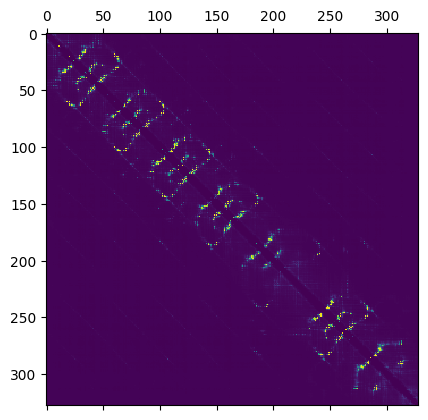

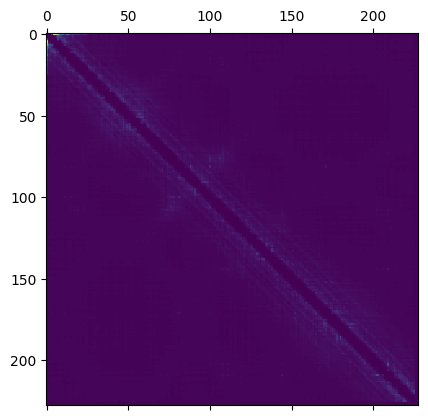

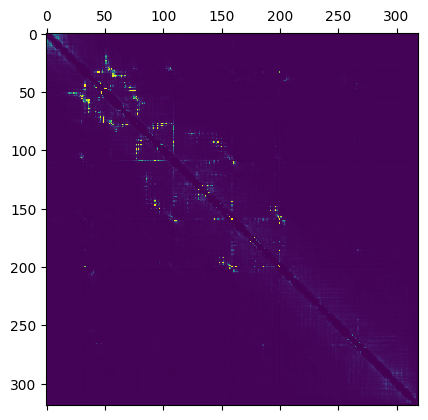

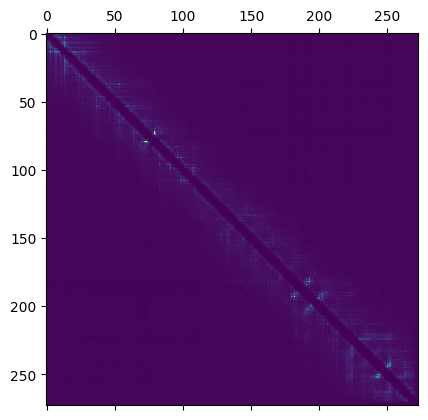

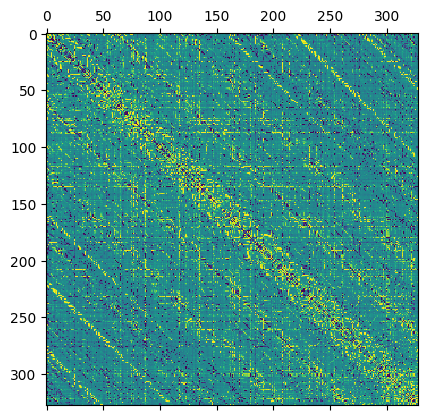

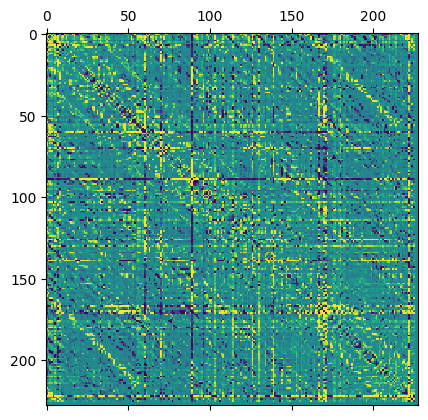

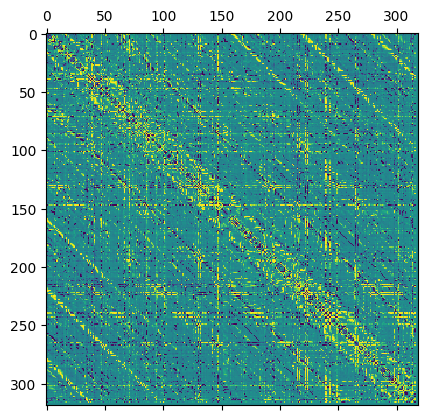

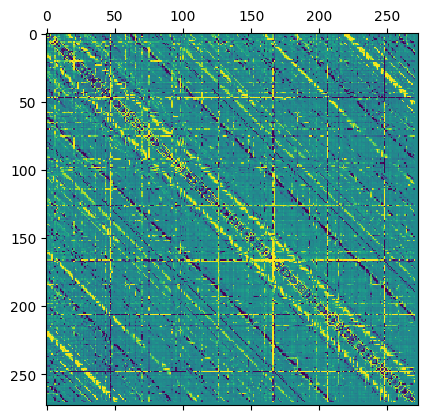

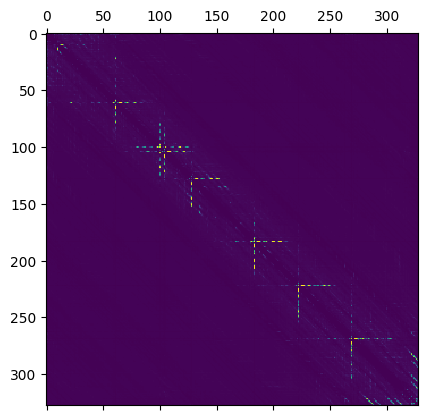

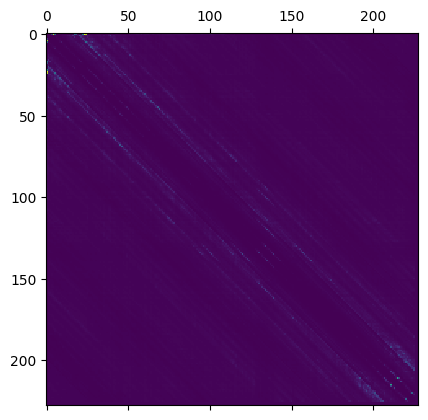

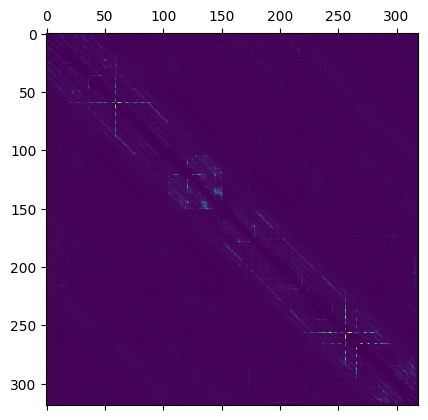

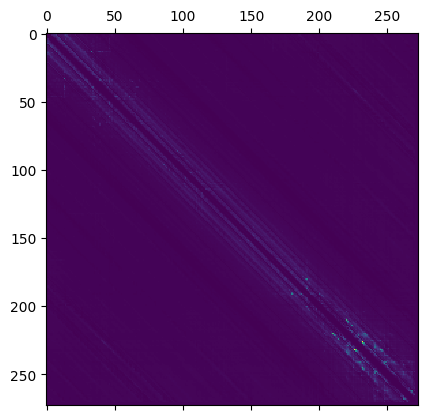

In [6]:
data = [
    ("O43684.1", "MTGSNEFKLNQPPEDGISSVKFSPNTSQFLLVSSWDTSVRLYDVPANSMRLKYQHTGAVLDCAFYDPTHAWSGGLDHQLKMHDLNTDQENLVGTHDAPIRCVEYCPEVNVMVTGSWDQTVKLWDPRTPCNAGTFSQPEKVYTLSVSGDRLIVGTAGRRVLVWDLRNMGYVQQRRESSLKYQTRCIRAFPNKQGYVLSSIEGRVAVEYLDPSPEVQKKKYAFKCHRLKENNIEQIYPVNAISFHNIHNTFATGGSDGFVNIWDPFNKKRLCQFHRYPTSIASLAFSNDGTTLAIASSYMYEMDDTEHPEDGIFIRQVTDAETKPKSPCT"),
    ("P00846.1", "MNENLFASFIAPTILGLPAAVLIILFPPLLIPTSKYLINNRLITTQQWLIKLTSKQMMTMHNTKGRTWSLMLVSLIIFIATTNLLGLLPHSFTPTTQLSMNLAMAIPLWAGTVIMGFRSKIKNALAHFLPQGTPTPLIPMLVIIETISLLIQPMALAVRLTANITAGHLLMHLIGSATLAMSTINLPSTLIIFTILILLTILEIAVALIQAYVFTLLVSLYLHDNT"),
    ("O14756","MWLYLAAFVGLYYLLHWYRERQVVSHLQDKYVFITGCDSGFGNLLARQLDARGLRVLAACLTEKGAEQLRGQTSDRLETVTLDVTKMESIAAATQWVKEHVGDRGLWGLVNNAGILTPITLCEWLNTEDSMNMLKVNLIGVIQVTLSMLPLVRRARGRIVNVSSILGRVAFFVGGYCVSKYGVEAFSDILRREIQHFGVKISIVEPGYFRTGMTNMTQSLERMKQSWKEAPKHIKETYGQQYFDALYNIMKEGLLNCSTNLNLVTDCMEHALTSVHPRTRYSAGWDAKFFFIPLSYLPTSLADYILTRSWPKPAQAV"),
    ("P01583",  "MAKVPDMFEDLKNCYSENEEDSSSIDHLSLNQKSFYHVSYGPLHEGCMDQSVSLSISETSKTSKLTFKESMVVVATNGKVLKKRRLSLSQSITDDDLEAIANDSEEEIIKPRSAPFSFLSNVKYNFMRIIKYEFILNDALNQSIIRANDQYLTAAALHNLDEAVKFDMGAYKSSKDDAKITVILRISKTQLYVTAQDEDQPVLLKEMPEIPKTITGSETNLLFFWETHGTKNYFTSVAHPNLFIATKQDYWVCLAGGPPSITDFQILENQA"),
]
res1 = esm_plot(model1, data)
res2 = esm_plot(model2, data)
res3 = esm_plot(model3, data)

In [7]:
def plot_subplots(res1, res2, res3):
    fig, axes = plt.subplots(3, 4, figsize=(15, 15))

    # Assuming each list (res1, res2, res3) contains 3 images
    for i in range(4):
        axes[0, i].imshow(res1[i])
        axes[1, i].imshow(res2[i])
        axes[2, i].imshow(res3[i])
        axes[0, i].axis('off')
        axes[1, i].axis('off')
        axes[2, i].axis('off')
    plt.tight_layout()
    plt.savefig('temp', dpi=600)
    plt.show()

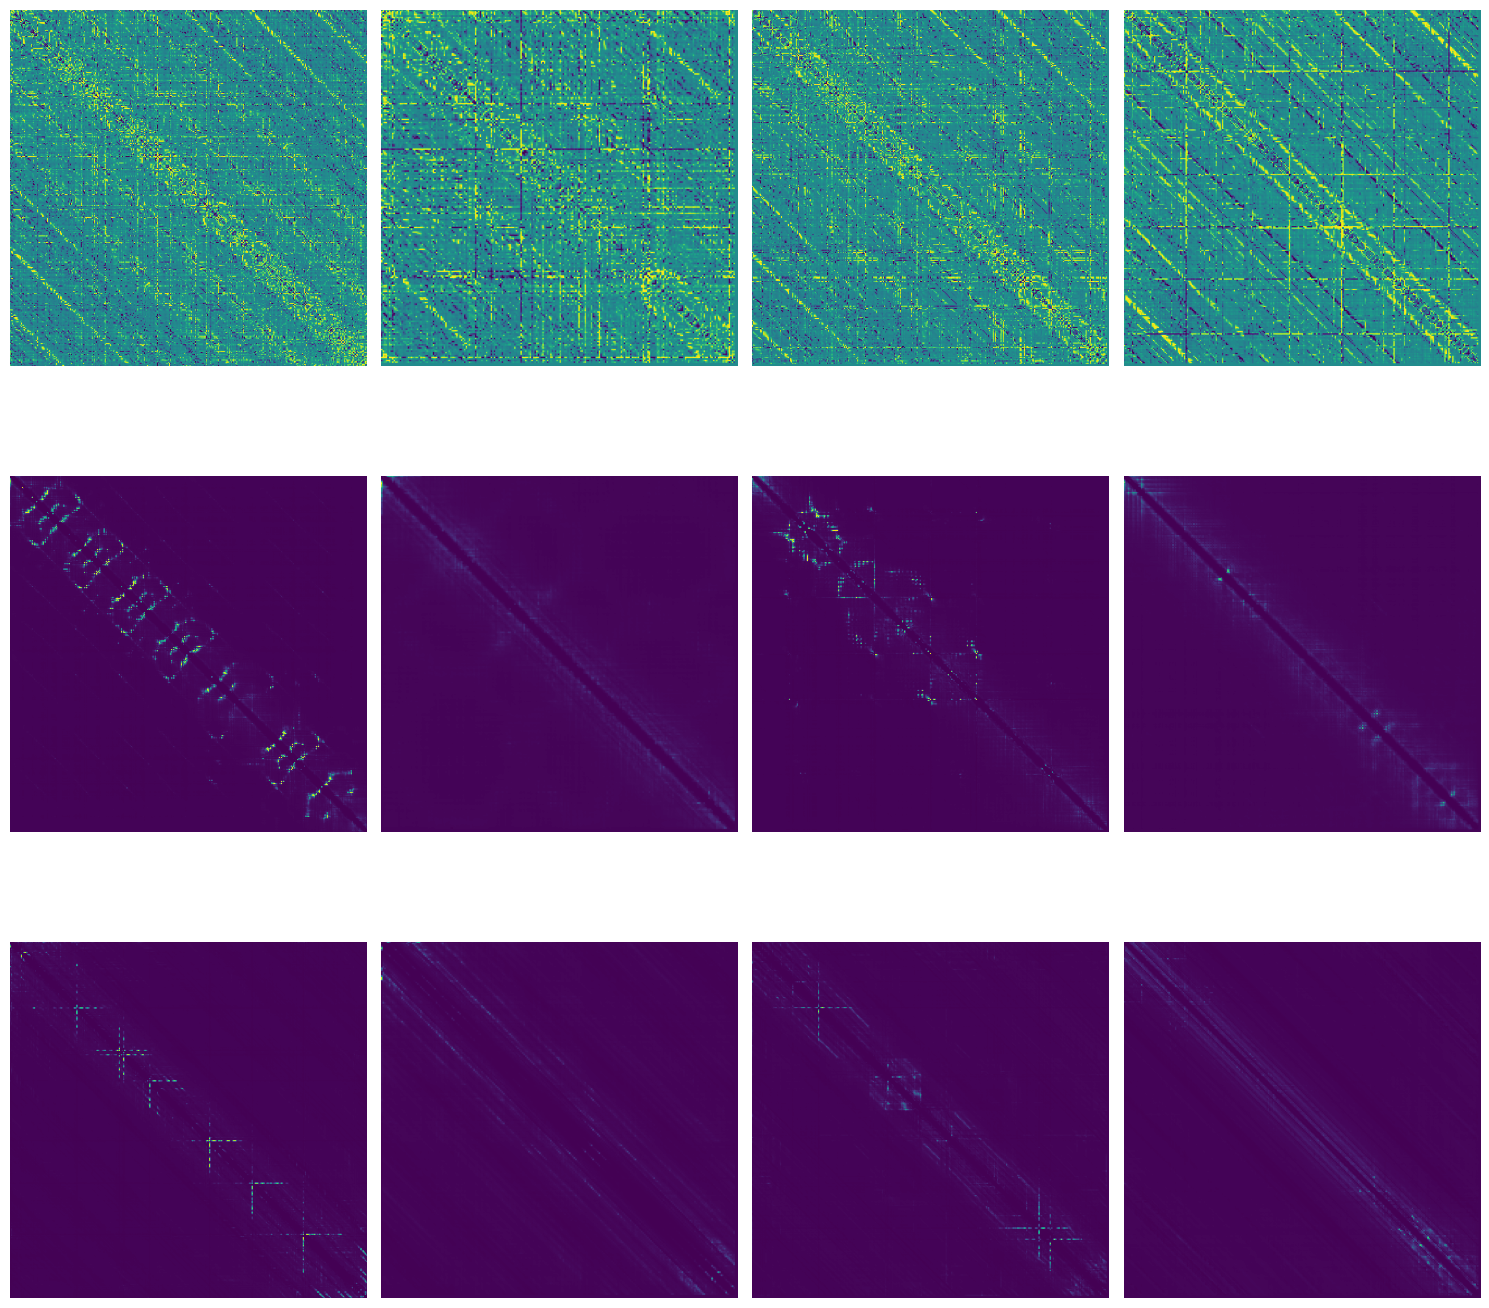

In [8]:
plot_subplots(res2, res1, res3)